In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('./data/data_indexes_moex_log_returns.csv', index_col=0)

In [3]:
from typing import List, Union


def MASE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Mean Absolute Scaled Error (MASE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение MASE.
    '''
    # Создание наивного прогноза с использованием сдвига временного ряда
    naive_forecast = y_true.shift(1)
    naive_forecast.iloc[0] = y_true.iloc[0]

    # Вычисление средней абсолютной ошибки для модели и наивного прогноза
    average_errors = (y_true - y_pred).abs()
    naive_average_errors = (y_true - naive_forecast).abs()

    result = average_errors.mean() / naive_average_errors.mean()
    return result


def SMAPE(y_true: pd.Series, y_pred: pd.Series) -> float:
    '''
    Вычисляет Symmetric Mean Absolute Percentage Error (SMAPE) между фактическими и прогнозируемыми значениями.

    Параметры:
            y_true (pd.Series): Серия с фактическими значениями.
            y_pred (pd.Series): Серия с прогнозируемыми значениями.

    Возвращаемое значение:
            float: Значение SMAPE.
    '''
    # Избегание деления на ноль добавлением небольшого числа в знаменатель
    denominator = np.abs(y_true) + np.abs(y_pred) + np.finfo(float).eps
    result = (200 / len(y_true)) * np.sum(np.abs(y_pred - y_true) / denominator)
    return result


class TimeSeriesProcessor:
    '''
    Класс для работы с временными рядами, включая добавление лагов, интеграцию внешних переменных,
    создание разбиений для валидации, вычисление метрик и визуализацию результатов.

    Методы:
        add_lags(self, lags: List[int], drop_na: bool = True):
            Добавление лагов к переменным временного ряда.
        add_other_variables(self, other_variables: pd.DataFrame):
            Добавление дополнительных переменных к данным.
        get_folds(self, horizon: int = 25):
            Создание разбиений данных для тестирования.
        get_model_result(self, y_pred_list: List[pd.Series]):
            Вычисление и вывод метрик для модели.
        get_visualisation(self):
            Визуализация фактических и прогнозируемых значений.
    '''
    def __init__(
            self, 
            data: Union[pd.Series, pd.DataFrame], 
            target_name: str = None,
            interpolate: bool = True,
            dropna: bool = True
            ) -> None:
        '''
        Инициализирует объект класса с данными временного ряда.

        Параметры:
            data (Union[pd.Series, pd.DataFrame]): Временной ряд в формате pd.Series или pd.DataFrame.
            target_name (str, опционально): Имя целевой переменной в случае pd.DataFrame.
            interpolate (bool): Необходимо ли интерполировать данные.
            dropna (bool): Необходимо ли удалить пропущенные значения.
        '''
        if not isinstance(data.index, pd.DatetimeIndex):
            print('Новый тип индексов: pd.DatetimeIndex')
            data.index = pd.to_datetime(data.index)
        
        if interpolate:
            data = data.interpolate(method='time')
        
        if dropna:
            data = data.dropna()

        if isinstance(data, pd.Series):
            if target_name is not None:
                print("Предупреждение: target_name не нужно указывать для data: pd.Series")
            self.y = data
            self.X = pd.DataFrame(index=self.y.index)
        else:
            if target_name is None:
                raise ValueError("target_name обязательный параметр для data: pd.DataFrame")
            self.y = data[target_name]
            self.X = data.drop([target_name], axis=1)

        self.get_folds_was_called = False
        self.y_pred = None

        self.y_val = None
        self.X_val = None

    def add_lags(self, lags: List[int], drop_na: bool = True) -> None:
        '''
        Добавляет лаги (отставания) к временному ряду как новые признаки.

        Параметры:
            lags (List[int]): Список целых чисел, каждое из которых указывает на количество шагов отставания.
            drop_na (bool): Если True, то строки с пропущенными значениями после добавления лагов будут удалены.
        '''
        for lag in lags:
            self.X[f'lag_{lag}'] = self.y.shift(lag)

        if drop_na:
            self.X.dropna(inplace=True)
            self.y = self.y.loc[self.X.index]

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def add_other_variables(self, other_variables: pd.DataFrame) -> None:
        '''
        Добавляет дополнительные внешние переменные к данным временного ряда.

        Параметры:
            other_variables (pd.DataFrame): DataFrame, содержащий внешние переменные для добавления.
        '''
        if other_variables.isna().any().any():
            print('Предупреждение: в other_variables есть пропуски. Алгоритм не предусматривает их наличие')

        self.X = pd.concat([self.X, other_variables], axis=1, join='inner')

        if self.get_folds_was_called:
            self.get_folds(horizon=self.horizon)

    def get_folds(
            self, 
            horizon: int = 25, 
            num_recent_folds: int = None, 
            validation_part: float = None
            ) -> None:
        '''
        Создает разбиения данных для кросс-валидации на основе указанного горизонта прогнозирования.

        Параметры:
            horizon (int): Горизонт прогнозирования, используемый для создания тестовых разбиений.
            num_recent_folds (int, optional): Количество последних разбиений для включения в результат.
                Если не указано, используются все разбиения.
            validation_part (float): Процентное отношение объема исходных данных, отводимое для валидационного набора. Этот параметр особенно полезен в случаях, когда оптимизация гиперпараметров модели требует значительного времени. Рекомендуется однократно настроить гиперпараметры на валидационном наборе и применять их для последующих разбиений (фолдов), избегая повторного обучения на каждом фолде.
                В случае отсутствия значения параметра, валидационная часть данных не формируется.
        '''

        if validation_part is not None:
            if not 0 <= validation_part <= 1:
                raise ValueError("validation_part может быть только числом в отрезке от 0 до 1 включительно")
            
            last_val_obs = int(self.y.shape[0] * validation_part)

            self.y_val, self.y = self.y.iloc[:last_val_obs], self.y.iloc[last_val_obs:]
            self.X_val, self.X = self.X.iloc[:last_val_obs, :], self.X.iloc[last_val_obs:, :]

        self.horizon = horizon
        self.folds = []
        for i in range(0, len(self.X) - horizon, horizon):
            X_test = self.X.iloc[i:i + horizon]
            y_test = self.y.iloc[i:i + horizon]

            X_train = self.X.drop(X_test.index)
            y_train = self.y.drop(y_test.index)
            
            self.folds.append((X_train, y_train, X_test, y_test))
        
        if num_recent_folds is not None:
            self.folds = self.folds[-num_recent_folds:]
        
        self.get_folds_was_called = True

    def get_model_result(self, y_pred_list: List[pd.Series]) -> None:
        '''
        Вычисляет и выводит метрики качества модели на основе совокупности предсказаний.

        Параметры:
            y_pred_list (List[pd.Series]): Список pd.Series с прогнозами модели для каждого разбиения.
        '''
        self.y_pred = pd.concat(y_pred_list)
        self.y_true = self.y.loc[self.y_pred.index]

        self.mase = MASE(self.y_true, self.y_pred)
        self.smape = SMAPE(self.y_true, self.y_pred)

        print(f'MASE: {self.mase:.2f} (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)')
        print(f'SMAPE: {self.smape:.2f}% (на сколько % в среднем модель ошибается)')

    def get_visualisation(self, start_date=None, end_date=None) -> None:
        '''
        Отображает визуализацию сравнения фактических значений временного ряда с прогнозными.
        
        Параметры:
            start_date (str, optional): Начальная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                        Если None, визуализация начинается с первой доступной даты.
            end_date (str, optional): Конечная дата среза для визуализации в формате 'YYYY-MM-DD'.
                                      Если None, визуализация идет до последней доступной даты.
        '''
        if self.y_pred is None:
            raise ValueError('Метод get_visualisation должен вызываться после вызова метода get_model_result')
        
        y_true_sliced = self.y_true.copy()
        y_pred_sliced = self.y_pred.copy()
        
        if start_date:
            y_true_sliced = y_true_sliced[start_date:]
            y_pred_sliced = y_pred_sliced[start_date:]
        if end_date:
            y_true_sliced = y_true_sliced[:end_date]
            y_pred_sliced = y_pred_sliced[:end_date]
        
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=y_true_sliced, label="Actual")
        sns.lineplot(data=y_pred_sliced, label="Predicted")
        plt.title("Actual vs Predicted")
        plt.legend()
        plt.show()

In [4]:
ts = TimeSeriesProcessor(data=data.MOEXCN)

Новый тип индексов: pd.DatetimeIndex


In [5]:
ts.add_lags(lags=[1, 2, 3, 4, 5, 10, 30])

In [6]:
ts.get_folds(horizon=20, validation_part=0.2, num_recent_folds=40)

# Тестирование различных моделей

### Случайный лес

In [7]:
from sklearn.ensemble import RandomForestRegressor

# Модель случайного леса
rf_model = RandomForestRegressor()

y_pred_list_rf = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    rf_model.fit(X_train, y_train)
    y_pred_rf = pd.Series(rf_model.predict(X_test), index=X_test.index)
    y_pred_list_rf.append(y_pred_rf) 

100%|██████████| 40/40 [04:31<00:00,  6.78s/it]


In [8]:
ts.get_model_result(y_pred_list_rf) 

MASE: 0.77 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 151.66% (на сколько % в среднем модель ошибается)


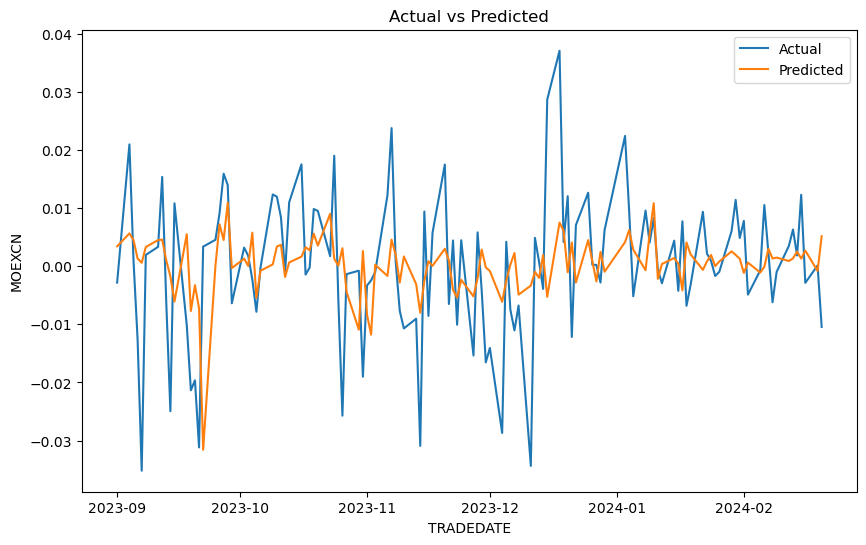

In [9]:
ts.get_visualisation(start_date='2023-09-01')

### Градиентный бустинг

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

# Модель градиентного бустинга
gb_model = GradientBoostingRegressor()

y_pred_list_gb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    gb_model.fit(X_train, y_train)
    y_pred_gb = pd.Series(gb_model.predict(X_test), index=X_test.index)
    y_pred_list_gb.append(y_pred_gb)

100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


In [11]:
ts.get_model_result(y_pred_list_gb) 

MASE: 0.76 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 160.52% (на сколько % в среднем модель ошибается)


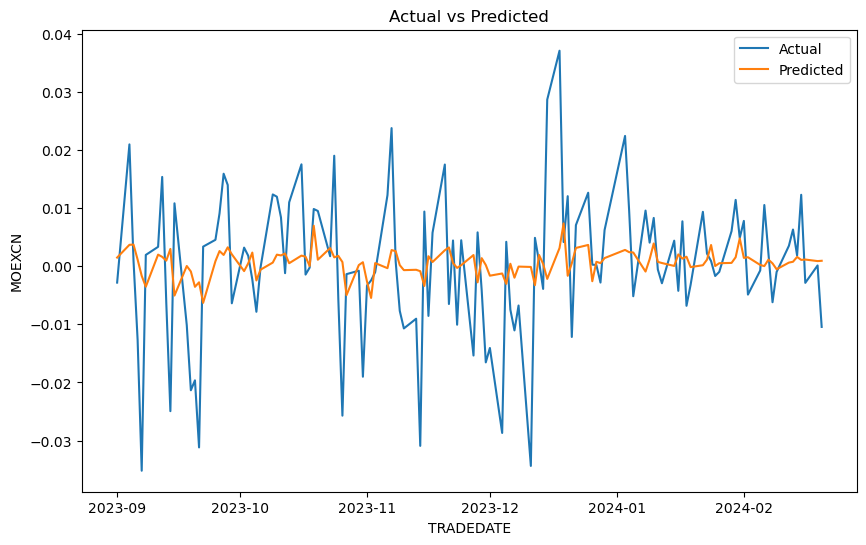

In [12]:
ts.get_visualisation(start_date='2023-09-01')

### SVR модель

In [13]:
from sklearn.svm import SVR

svr_model = SVR()

y_pred_list_svr = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    svr_model.fit(X_train, y_train)
    y_pred_svr = pd.Series(svr_model.predict(X_test), index=X_test.index)
    y_pred_list_svr.append(y_pred_svr)

100%|██████████| 40/40 [00:00<00:00, 99.14it/s] 


In [14]:
ts.get_model_result(y_pred_list_svr) 

MASE: 1.82 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 156.94% (на сколько % в среднем модель ошибается)


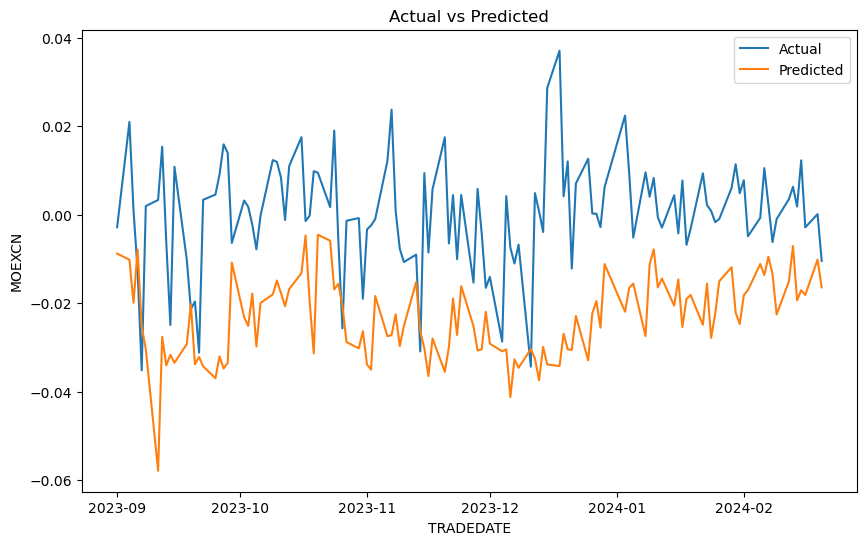

In [15]:
ts.get_visualisation(start_date='2023-09-01')

### Адаптивный бустинг

In [16]:
from sklearn.ensemble import AdaBoostRegressor

adaboost_model = AdaBoostRegressor()

y_pred_list_adaboost = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    adaboost_model.fit(X_train, y_train)
    y_pred_adaboost = pd.Series(adaboost_model.predict(X_test), index=X_test.index)
    y_pred_list_adaboost.append(y_pred_adaboost)

100%|██████████| 40/40 [00:08<00:00,  4.58it/s]


In [17]:
ts.get_model_result(y_pred_list_adaboost) 

MASE: 0.81 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 160.68% (на сколько % в среднем модель ошибается)


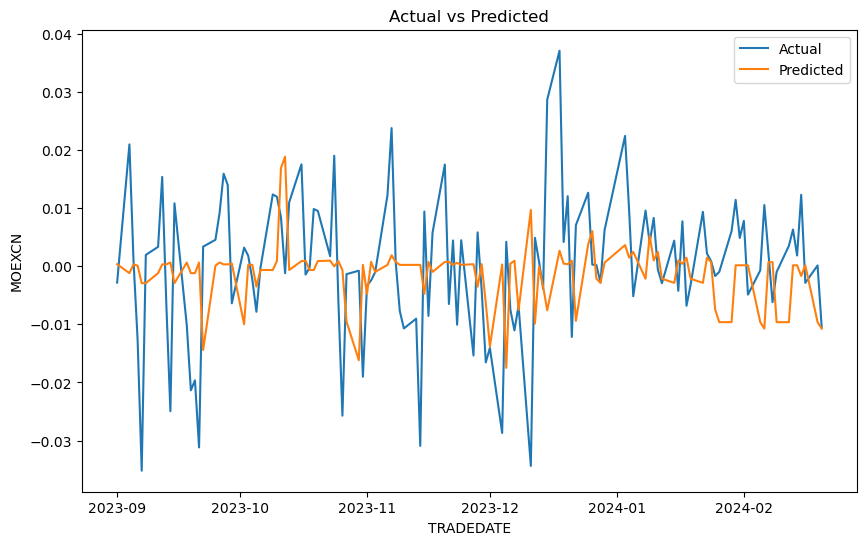

In [18]:
ts.get_visualisation(start_date='2023-09-01')

### Lasso-регрессия

In [22]:
from sklearn.linear_model import Lasso

lasso_model = Lasso()

y_pred_list_lasso = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    lasso_model.fit(X_train, y_train)
    y_pred_lasso = pd.Series(lasso_model.predict(X_test), index=X_test.index)
    y_pred_list_lasso.append(y_pred_lasso)

100%|██████████| 40/40 [00:00<00:00, 162.43it/s]


In [23]:
ts.get_model_result(y_pred_list_lasso) 

MASE: 0.75 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 176.15% (на сколько % в среднем модель ошибается)


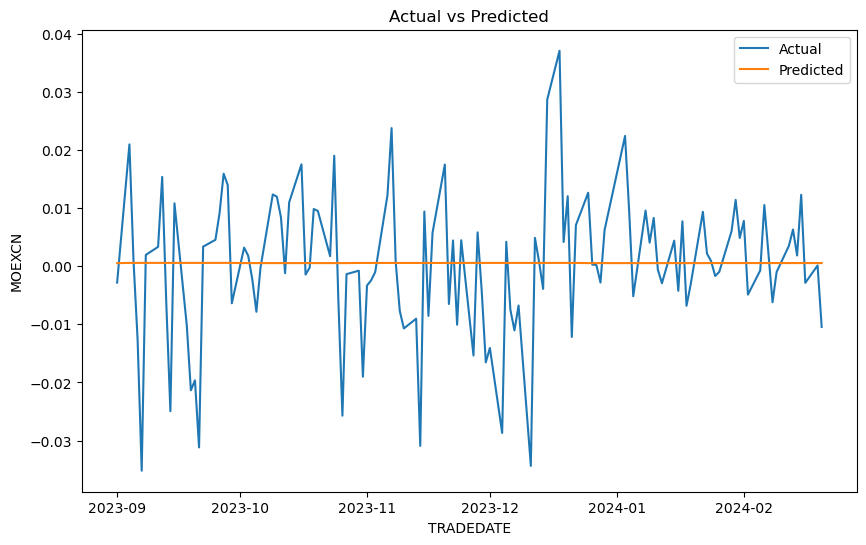

In [24]:
ts.get_visualisation(start_date='2023-09-01')

### Ridge-регрессия

In [25]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

y_pred_list_ridge = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = pd.Series(ridge_model.predict(X_test), index=X_test.index)
    y_pred_list_ridge.append(y_pred_ridge)

100%|██████████| 40/40 [00:00<00:00, 172.57it/s]


In [26]:
ts.get_model_result(y_pred_list_ridge) 

MASE: 0.75 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 174.04% (на сколько % в среднем модель ошибается)


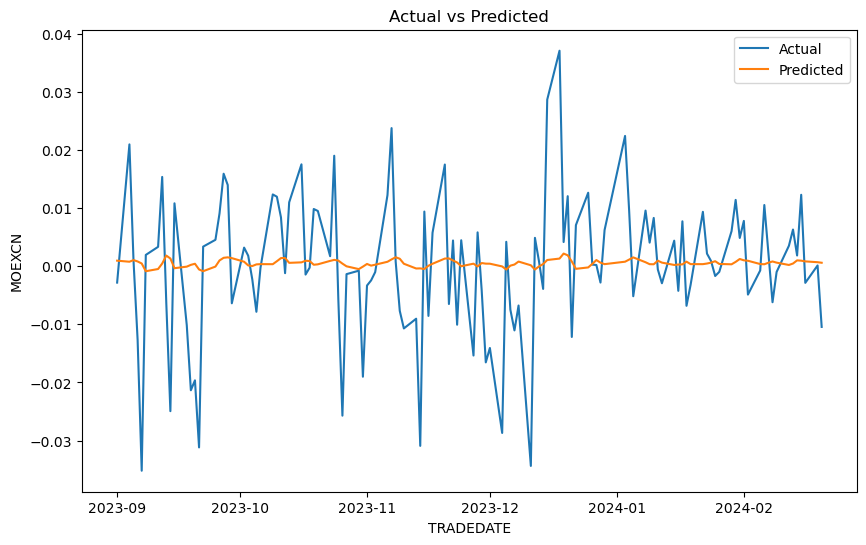

In [27]:
ts.get_visualisation(start_date='2023-09-01')

### К-ближайших соседей 

In [28]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()

y_pred_list_knn = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    knn_model.fit(X_train, y_train)
    y_pred_knn = pd.Series(knn_model.predict(X_test), index=X_test.index)
    y_pred_list_knn.append(y_pred_knn)

100%|██████████| 40/40 [00:00<00:00, 83.84it/s]


In [29]:
ts.get_model_result(y_pred_list_knn) 

MASE: 0.80 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 147.46% (на сколько % в среднем модель ошибается)


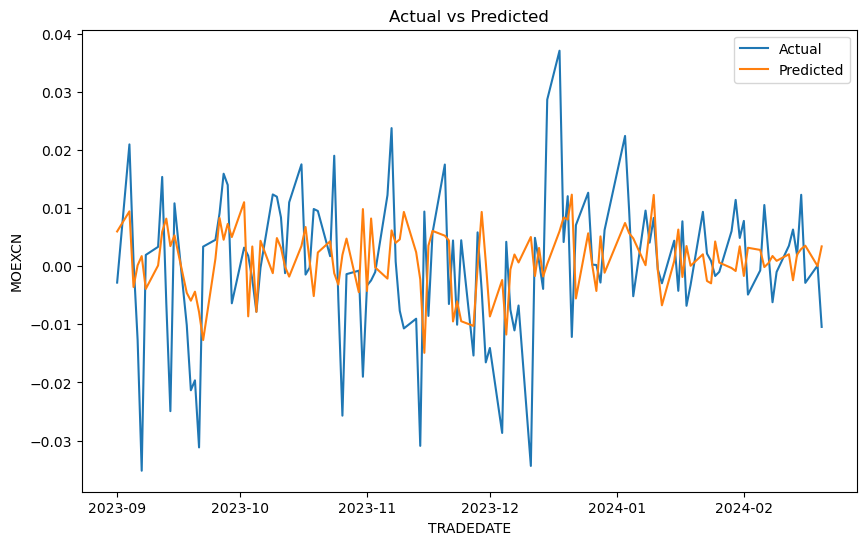

In [30]:
ts.get_visualisation(start_date='2023-09-01')

### XGBoost

In [40]:
import xgboost as xgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna

X_val, y_val = ts.X_val, ts.y_val

# Создаем скорер для использования в cross_val_score
smape_scorer = make_scorer(SMAPE)

def objective(trial):
    
    param = {
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Скорость обучения
    'max_depth': trial.suggest_int('max_depth', 3, 10),  # Максимальная глубина деревьев
    'gamma': trial.suggest_float('gamma', 0.0, 1.0),  # Минимальное снижение значения функции потерь, чтобы сделать разделение
    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 100.0),  # L1 регуляризация
    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 100.0),  # L2 регуляризация
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # Доля наблюдений, используемая для обучения каждого дерева
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Доля признаков, используемая для обучения каждого дерева
    'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),  # Минимальный вес дочерних узлов
    'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # Количество деревьев
    }
    
    regressor = xgb.XGBRegressor(**param)
    return np.mean(
        cross_val_score(
            regressor, X_val, y_val, 
            n_jobs=-1, scoring=smape_scorer, 
            cv=5))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-03-15 22:40:48,209] A new study created in memory with name: no-name-b5c5aedf-065a-4f82-9648-923127cd360a
[I 2024-03-15 22:40:48,333] Trial 0 finished with value: 173.15542546053598 and parameters: {'learning_rate': 0.09974258034452052, 'max_depth': 5, 'gamma': 0.22737377703629724, 'reg_alpha': 0.5223079817419911, 'reg_lambda': 0.0059349942332614395, 'subsample': 0.8088636077434044, 'colsample_bytree': 0.8337390971946957, 'min_child_weight': 7.0150954004325214, 'n_estimators': 234}. Best is trial 0 with value: 173.15542546053598.
[I 2024-03-15 22:40:48,435] Trial 1 finished with value: 173.5847980169609 and parameters: {'learning_rate': 0.10458972791877087, 'max_depth': 3, 'gamma': 0.8865902769838663, 'reg_alpha': 3.1429249429285244e-06, 'reg_lambda': 0.007176983579750943, 'subsample': 0.9368451120424562, 'colsample_bytree': 0.8772397781150573, 'min_child_weight': 9.23348351402548, 'n_estimators': 200}. Best is trial 0 with value: 173.15542546053598.
[I 2024-03-15 22:40:48,743]

In [41]:
study.best_params

{'learning_rate': 0.04465736934692652,
 'max_depth': 6,
 'gamma': 0.0007525131196680634,
 'reg_alpha': 1.311847915855058e-08,
 'reg_lambda': 7.629787620487013e-06,
 'subsample': 0.7048067471184322,
 'colsample_bytree': 0.6698137050279903,
 'min_child_weight': 6.3957769068003785,
 'n_estimators': 814}

In [42]:
optuna.visualization.plot_optimization_history(study)

In [43]:
optuna.visualization.plot_slice(study)

In [50]:
xgb_model = xgb.XGBRegressor(**study.best_params)

y_pred_list_xgb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = pd.Series(xgb_model.predict(X_test), index=X_test.index)
    y_pred_list_xgb.append(y_pred_xgb)

100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


In [51]:
ts.get_model_result(y_pred_list_xgb) 

MASE: 0.78 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 158.38% (на сколько % в среднем модель ошибается)


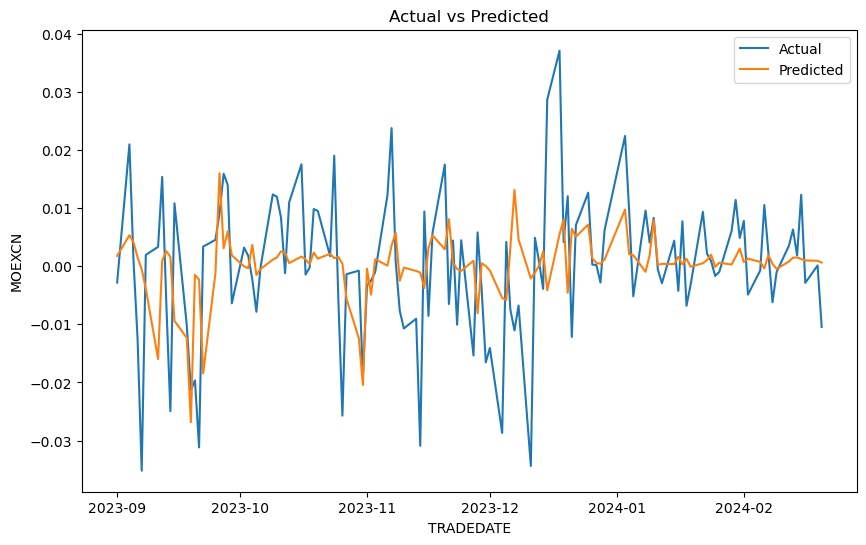

In [52]:
ts.get_visualisation(start_date='2023-09-01')

In [53]:
#Без поиска параметров работает лучше почему-то..
xgb_model = xgb.XGBRegressor()

y_pred_list_xgb = []

for X_train, y_train, X_test, y_test in tqdm(ts.folds):
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = pd.Series(xgb_model.predict(X_test), index=X_test.index)
    y_pred_list_xgb.append(y_pred_xgb)

100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


In [54]:
ts.get_model_result(y_pred_list_xgb) 

MASE: 0.83 (во сколько раз абсолютная ошибка прогноза меньше абсолютной ошибки наивного прогноза)
SMAPE: 149.24% (на сколько % в среднем модель ошибается)


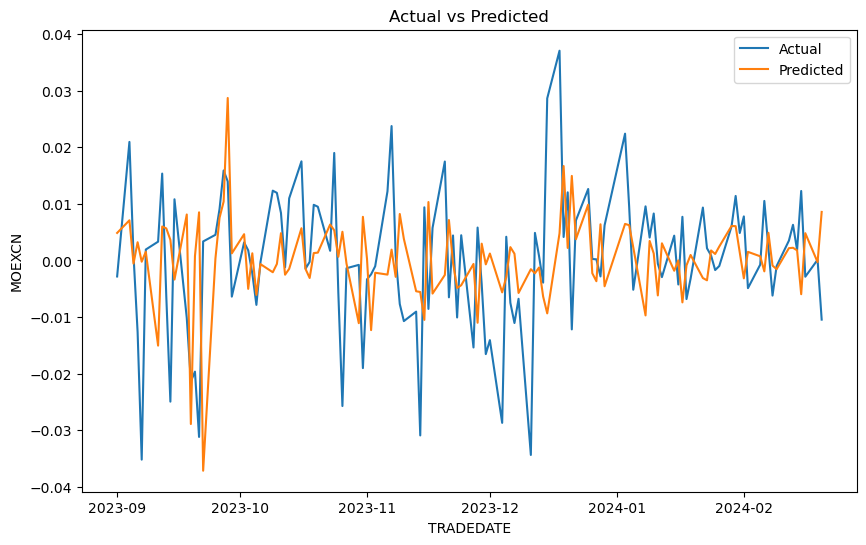

In [55]:
ts.get_visualisation(start_date='2023-09-01')